## Step 0: Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

In [2]:
# Horizon / lookback used before
H = 3
LOOKBACK = 14

PRED_DIR = "outputs/predictions"

# Paths 
paths = {
    "LogReg": os.path.join(PRED_DIR, f"logreg_predictions_H{H}.csv"),
    "MLP":    os.path.join(PRED_DIR, f"mlp_predictions_H{H}.csv"),
    "CNN":    os.path.join(PRED_DIR, f"cnn_predictions_H{H}_L{LOOKBACK}.csv"),
    "LSTM":   os.path.join(PRED_DIR, f"lstm_predictions_H{H}_L{LOOKBACK}.csv"),
}


In [3]:
# Load everything
preds = {}
for name, p in paths.items():
    if not os.path.exists(p):
        print("Missing file:", name, "->", p)
    else:
        df = pd.read_csv(p, parse_dates=["date"])
        preds[name] = df
        print(f"{name}: loaded {len(df)} rows")

list(preds.keys()), preds[list(preds.keys())[0]].head()

LogReg: loaded 256 rows
MLP: loaded 256 rows
CNN: loaded 178 rows
LSTM: loaded 178 rows


(['LogReg', 'MLP', 'CNN', 'LSTM'],
         date  ticker_id  proba_up  pred_up  actual_up  correct
 0 2023-11-05          1  0.567015        1          0        0
 1 2023-11-05          2  0.411166        0          1        0
 2 2023-11-06          0  0.559495        1          1        1
 3 2023-11-06          1  0.542309        1          0        0
 4 2023-11-06          2  0.403494        0          1        0)

## Step 1: Compute metrics 

We compute the same metrics for each model.

In [4]:
rows = []

for name, df in preds.items():
    y_true = df["actual_up"].to_numpy()
    y_pred = df["pred_up"].to_numpy()
    y_prob = df["proba_up"].to_numpy()

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    # simple classification metrics (treat "up"=1 as positive class)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    rows.append({
        "model": name,
        "accuracy": acc,
        "auc": auc,
        "precision_up": prec,
        "recall_up": rec,
        "f1_up": f1,
        "n": len(df)
    })

metrics_df = pd.DataFrame(rows).sort_values("auc", ascending=False)


In [5]:
metrics_df_display = metrics_df.copy()
for c in ["accuracy", "auc", "precision_up", "recall_up", "f1_up"]:
    metrics_df_display[c] = metrics_df_display[c].map(lambda x: round(float(x), 3))

metrics_df_display

,model,accuracy,auc,precision_up,recall_up,f1_up,n
3,LSTM,0.601,0.579,0.564,0.543,0.553,178
2,CNN,0.528,0.566,0.486,0.630,0.548,178
0,LogReg,0.527,0.548,0.539,0.617,0.575,256
1,MLP,0.547,0.530,0.555,0.647,0.597,256


## Step 2: Visualise the comparison



In [6]:
plot_df = metrics_df.sort_values("model").copy()

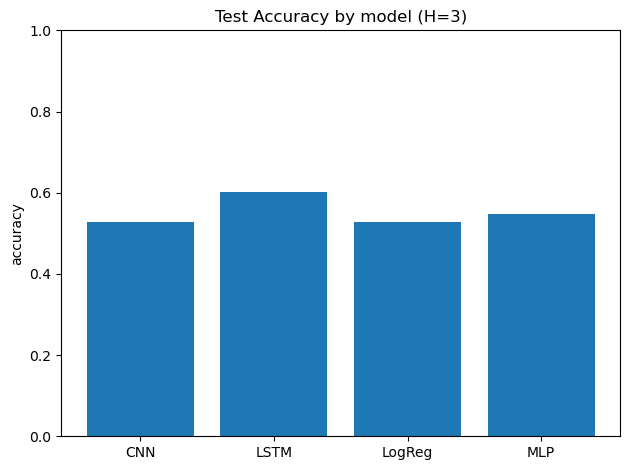

In [7]:
# Accuracy bar chart
plt.figure()
plt.bar(plot_df["model"], plot_df["accuracy"])
plt.title(f"Test Accuracy by model (H={H})")
plt.ylabel("accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

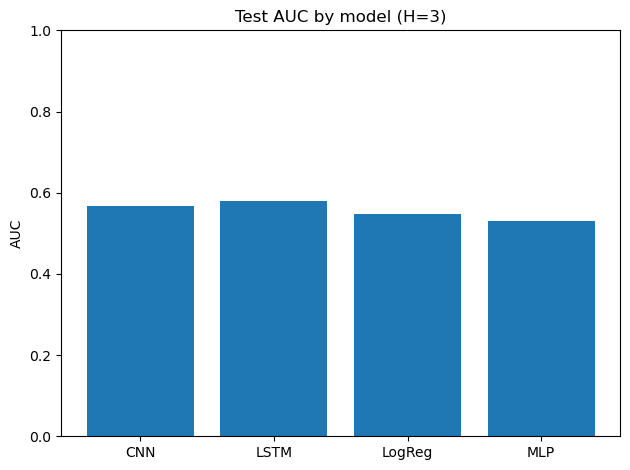

In [8]:
# AUC bar chart
plt.figure()
plt.bar(plot_df["model"], plot_df["auc"])
plt.title(f"Test AUC by model (H={H})")
plt.ylabel("AUC")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Step 3: Sanity check that test sets match 

Here we verify that each model is evaluated on the same `(date, ticker_id)` rows, or at least show the overlap.
This way we make the comparison fair and explain if CNN/LSTM have fewer samples because of lookback.


In [9]:
# Build a key set for each model: 
key_sets = {}
for name, df in preds.items():
    keys = set(zip(df["date"].astype(str), df["ticker_id"]))
    key_sets[name] = keys
    print(name, "unique rows:", len(keys))

# Intersection across all models
common = None
for name, s in key_sets.items():
    common = s if common is None else common.intersection(s)

print("\nCommon rows across ALL models:", len(common))

LogReg unique rows: 256
MLP unique rows: 256
CNN unique rows: 178
LSTM unique rows: 178

Common rows across ALL models: 178


In [10]:
# Show how many rows each model would lose if we restrict to common set
for name, s in key_sets.items():
    print(f"{name}: would keep {len(common)} / {len(s)} rows")

LogReg: would keep 178 / 256 rows
MLP: would keep 178 / 256 rows
CNN: would keep 178 / 178 rows
LSTM: would keep 178 / 178 rows


## Step 4: Compare on the *same* test rows and per-ticker results 

We restrict all models to the shared `(date, ticker_id)` rows, recompute metrics fairly, then compute per-ticker accuracy.
As sequence models may have fewer test samples (lookback), this makes the comparison fair and easier to explain.


In [11]:
# Restrict all models to the common test rows for comparing

common = None
for name, df in preds.items():
    s = set(zip(df["date"].astype(str), df["ticker_id"]))
    common = s if common is None else common.intersection(s)

print("Common rows:", len(common))

def filter_to_common(df, common_keys):
    df = df.copy()
    df["_key"] = list(zip(df["date"].astype(str), df["ticker_id"]))
    df = df[df["_key"].isin(common_keys)].drop(columns="_key")
    return df.sort_values(["date", "ticker_id"]).reset_index(drop=True)

preds_common = {name: filter_to_common(df, common) for name, df in preds.items()}

# sanity: all the same length now
for name, df in preds_common.items():
    print(name, len(df))


Common rows: 178
LogReg 178
MLP 178
CNN 178
LSTM 178


In [12]:
# Recompute metrics fairly on the common rows
rows = []
for name, df in preds_common.items():
    y_true = df["actual_up"].to_numpy()
    y_pred = df["pred_up"].to_numpy()
    y_prob = df["proba_up"].to_numpy()

    rows.append({
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "auc": roc_auc_score(y_true, y_prob),
        "precision_up": precision_score(y_true, y_pred, zero_division=0),
        "recall_up": recall_score(y_true, y_pred, zero_division=0),
        "f1_up": f1_score(y_true, y_pred, zero_division=0),
        "n_common": len(df)
    })

metrics_common = pd.DataFrame(rows).sort_values("auc", ascending=False)

metrics_common_display = metrics_common.copy()
for c in ["accuracy", "auc", "precision_up", "recall_up", "f1_up"]:
    metrics_common_display[c] = metrics_common_display[c].map(lambda x: round(float(x), 3))

metrics_common_display

,model,accuracy,auc,precision_up,recall_up,f1_up,n_common
3,LSTM,0.601,0.579,0.564,0.543,0.553,178
2,CNN,0.528,0.566,0.486,0.630,0.548,178
1,MLP,0.545,0.540,0.500,0.630,0.557,178
0,LogReg,0.500,0.528,0.463,0.617,0.529,178


In [13]:
# Accuracy per ticker
per_ticker_rows = []

for name, df in preds_common.items():
    tmp = df.copy()
    tmp["correct"] = (tmp["pred_up"] == tmp["actual_up"]).astype(int)

    acc_by_ticker = tmp.groupby("ticker_id")["correct"].mean().reset_index()
    acc_by_ticker["model"] = name
    per_ticker_rows.append(acc_by_ticker)

per_ticker_df = pd.concat(per_ticker_rows, ignore_index=True)

per_ticker_pivot = per_ticker_df.pivot(index="ticker_id", columns="model", values="correct").reset_index()

per_ticker_pivot

model,ticker_id,CNN,LSTM,LogReg,MLP
0,0,0.458333,0.708333,0.500000,0.666667
1,1,0.487805,0.634146,0.536585,0.609756
2,2,0.463415,0.463415,0.463415,0.463415
3,3,0.583333,0.625000,0.375000,0.458333
4,4,0.375000,0.666667,0.375000,0.416667
5,5,0.875000,0.583333,0.750000,0.666667


In [14]:
# Save tables
os.makedirs("outputs", exist_ok=True)

metrics_common.to_csv("outputs/metrics_common.csv", index=False)
per_ticker_pivot.to_csv("outputs/per_ticker_accuracy_common.csv", index=False)

print("Saved: outputs/metrics_common.csv")
print("Saved: outputs/per_ticker_accuracy_common.csv")

Saved: outputs/metrics_common.csv
Saved: outputs/per_ticker_accuracy_common.csv
